# Examples of pfr Usage

There are 3 types of estimation that can be performed in the batch/pfr module: maximum a     
posteriori (MAP), Markov chain Monte Carlo (MCMC), and variational inference (VI).      
Below, we demonstrate all of these types on the same dataset. Please view the referenced    
Excel input file to see how the data should be input.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz
import seaborn as sns
import matplotlib.patches as mpatches
from ckbit import pfr
from scipy.stats.kde import gaussian_kde
from scipy.integrate import solve_ivp

First, we generate the PFR data with experimental noise added to the concentrations.   
The smooth lines are the unperturbed data, and the data points are the noisy    
measurements we use as our data points.

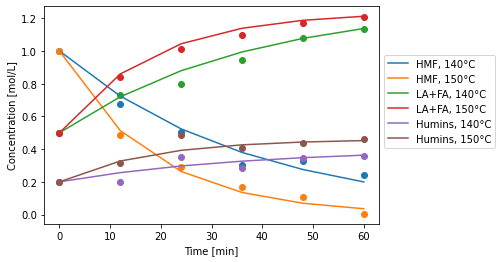

In [2]:
#Seed 5 was standalone
np.random.seed(5)
HMFinit = 1
LFinit = 0.5
Huinit = 0.2
numPoints = 6
taus = np.linspace (0,60,numPoints)
Hconc = 0.1
T = [413,423]
R = 8.31446261815324*(1/1000) #units of kJ/(mol*K)

#True params
sigma = HMFinit*0.05
A0HLF = 11.31
A0HHu = 16.69
EaHLF = 94.72
EaHHu = 141.94

try:
    del cHMF0,cHMF1,cLF0,cLF1,cHu0,cHu1
except:
    pass

size0 = len(taus)
cHMF0 = np.linspace(10,20,size0)
cHMF1 = np.linspace(10,20,size0)
cLF0 = np.linspace(10,20,size0)
cLF1 = np.linspace(10,20,size0)
cHu0 = np.linspace(10,20,size0)
cHu1 = np.linspace(10,20,size0)
total0 = np.linspace(10,20,size0)
total1 = np.linspace(10,20,size0)

def d0(t,y):
    dHMF = -(y[0]*Hconc)*(kHLF0+kHHu0)
    dLF = kHLF0*y[0]*Hconc
    dHu = kHHu0*y[0]*Hconc
    return [dHMF, dLF, dHu]

def d1(t,y):
    dHMF = -(y[0]*Hconc)*(kHLF1+kHHu1)
    dLF = kHLF1*y[0]*Hconc
    dHu = kHHu1*y[0]*Hconc
    return [dHMF, dLF, dHu]
    
kHLF0 = (10**A0HLF)*np.exp(-EaHLF/(R*T[0]))
kHLF1 = (10**A0HLF)*np.exp(-EaHLF/(R*T[1]))
kHHu0 = (10**A0HHu)*np.exp(-EaHHu/(R*T[0]))
kHHu1 = (10**A0HHu)*np.exp(-EaHHu/(R*T[1]))
tspan = [min(taus),max(taus)]

#clean data
c0 = solve_ivp(d0, tspan, [HMFinit, LFinit, Huinit], method='BDF', t_eval=taus).y
c1 = solve_ivp(d1, tspan, [HMFinit, LFinit, Huinit], method='BDF', t_eval=taus).y
cHMF0 = c0[0]
cLF0 = c0[1]
cHu0 = c0[2]
cHMF1 = c1[0]
cLF1 = c1[1]
cHu1 = c1[2]

f, ax = plt.subplots(1)
ax.plot(taus,cHMF0, label='HMF, 140°C')
ax.plot(taus,cHMF1, label='HMF, 150°C')
ax.plot(taus,cLF0, label='LA+FA, 140°C')
ax.plot(taus,cLF1, label='LA+FA, 150°C')
ax.plot(taus,cHu0, label='Humins, 140°C')
ax.plot(taus,cHu1, label='Humins, 150°C')

#noisy data
for i in range(size0):
    cHMF0[i] = cHMF0[i]+np.random.normal(0,sigma,1)
    cHMF1[i] = cHMF1[i]+np.random.normal(0,sigma,1)
    cLF0[i] = cLF0[i]+np.random.normal(0,sigma,1)
    cLF1[i] = cLF1[i]+np.random.normal(0,sigma,1)
    cHu0[i] = cHu0[i]+np.random.normal(0,sigma,1)
    cHu1[i] = cHu1[i]+np.random.normal(0,sigma,1)
    total0[i] = cHMF0[i]+cLF0[i]+cHu0[i]
    total1[i] = cHMF1[i]+cLF1[i]+cHu1[i]
 
cHMF0[0] = HMFinit
cHMF1[0] = HMFinit
cLF0[0] = LFinit
cLF1[0] = LFinit
cHu0[0] = Huinit
cHu1[0] = Huinit
    
for i in range (len(cHMF0)): 
    cHMF0[i] = max(0,cHMF0[i])
    cHMF1[i] = max(0,cHMF1[i])
    cLF0[i] = max(0,cLF0[i])
    cLF1[i] = max(0,cLF1[i])
    cHu0[i] = max(0,cHu0[i])
    cHu1[i] = max(0,cHu1[i])

#Plot the data
ax.scatter(taus,cHMF0)
ax.scatter(taus,cHMF1)
ax.scatter(taus,cLF0)
ax.scatter(taus,cLF1)
ax.scatter(taus,cHu0)
ax.scatter(taus,cHu1)
ax.set_xlabel('Time [min]')
ax.set_ylabel('Concentration [mol/L]')
#ax.set_title('Simulated Data with 5% Noise Addition')
ax.legend(bbox_to_anchor = (1,0.8))
plt.show()

We write this data into the appropriate format in an Excel file (see the Excel file named PFR_Data in this folder). Then we can use this data to obtain our estimates.
First, the MAP estimation. This yields point estimates of the modes of the posterior.    
These estimates are the values that fit the model best given the data and priors.

In [3]:
#Import data
file = './PFR_Data.xlsx'

#Run MAP estimation with standard priors
map1 = pfr.MAP(filename=file, pH=True, rel_tol=5E-6, abs_tol=5E-6, max_num_steps=1000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_82e6a9b54a623ac5604ef005a61f1bc0 NOW.


Parameter       Estimate
-----------  -----------
A0[1]         10.67
A0[2]         16.67
Ea[1]         89.8
Ea[2]        141.67
sigma          0.0381586
Runtime (min): 1.8133


Now, the MCMC estimation. This yields estimates of the posterior distributions of   
each parameter being estimated.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ae81a4b787362df01df8087f4bc0be3 NOW.


Inference for Stan model: anon_model_1ae81a4b787362df01df8087f4bc0be3.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A0[1]  10.62    0.06   1.35   7.95   9.77  10.63  11.54  13.17    590    1.0
A0[2]  16.71    0.11   2.97  10.77  14.79  16.68  18.58  22.75    683    1.0
Ea[1]  89.41    0.44   10.8   68.0  82.64  89.48  96.74 109.67    590    1.0
Ea[2] 142.05    0.91  23.86  94.25 126.53 141.79 157.06 190.72    684    1.0
sigma   0.04  2.1e-4 6.2e-3   0.03   0.04   0.04   0.05   0.06    846    1.0
lp__   89.62    0.08   1.73  85.17  88.75  89.97   90.9  91.96    420   1.01

Samples were drawn using NUTS at Sun Jun 28 17:07:34 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


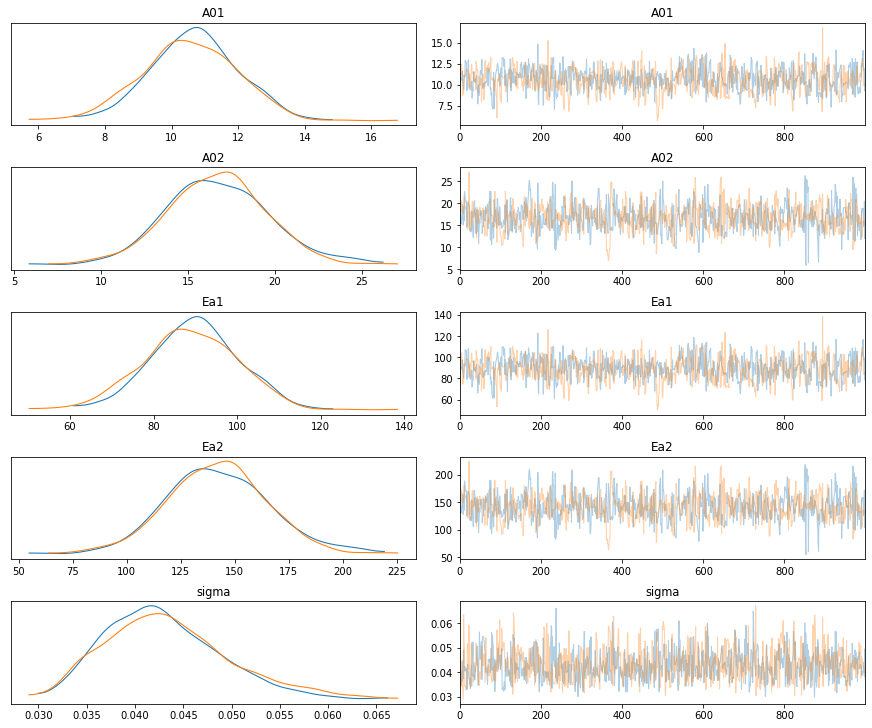

Runtime (min): 22.1289


In [4]:
#Run MCMC estimation with standard priors
m1, m2 = pfr.MCMC(filename=file, pH=True)

There are convergence checks to ensure that these samples can be relied upon.   
These checks are discussed in detail in the published article. This run passes all    
those checks, and offers a successful inference we can trust.

It is important to visualize the correlation that exists between the samples of    
the parameters, which we can accomplish with a pair plot.

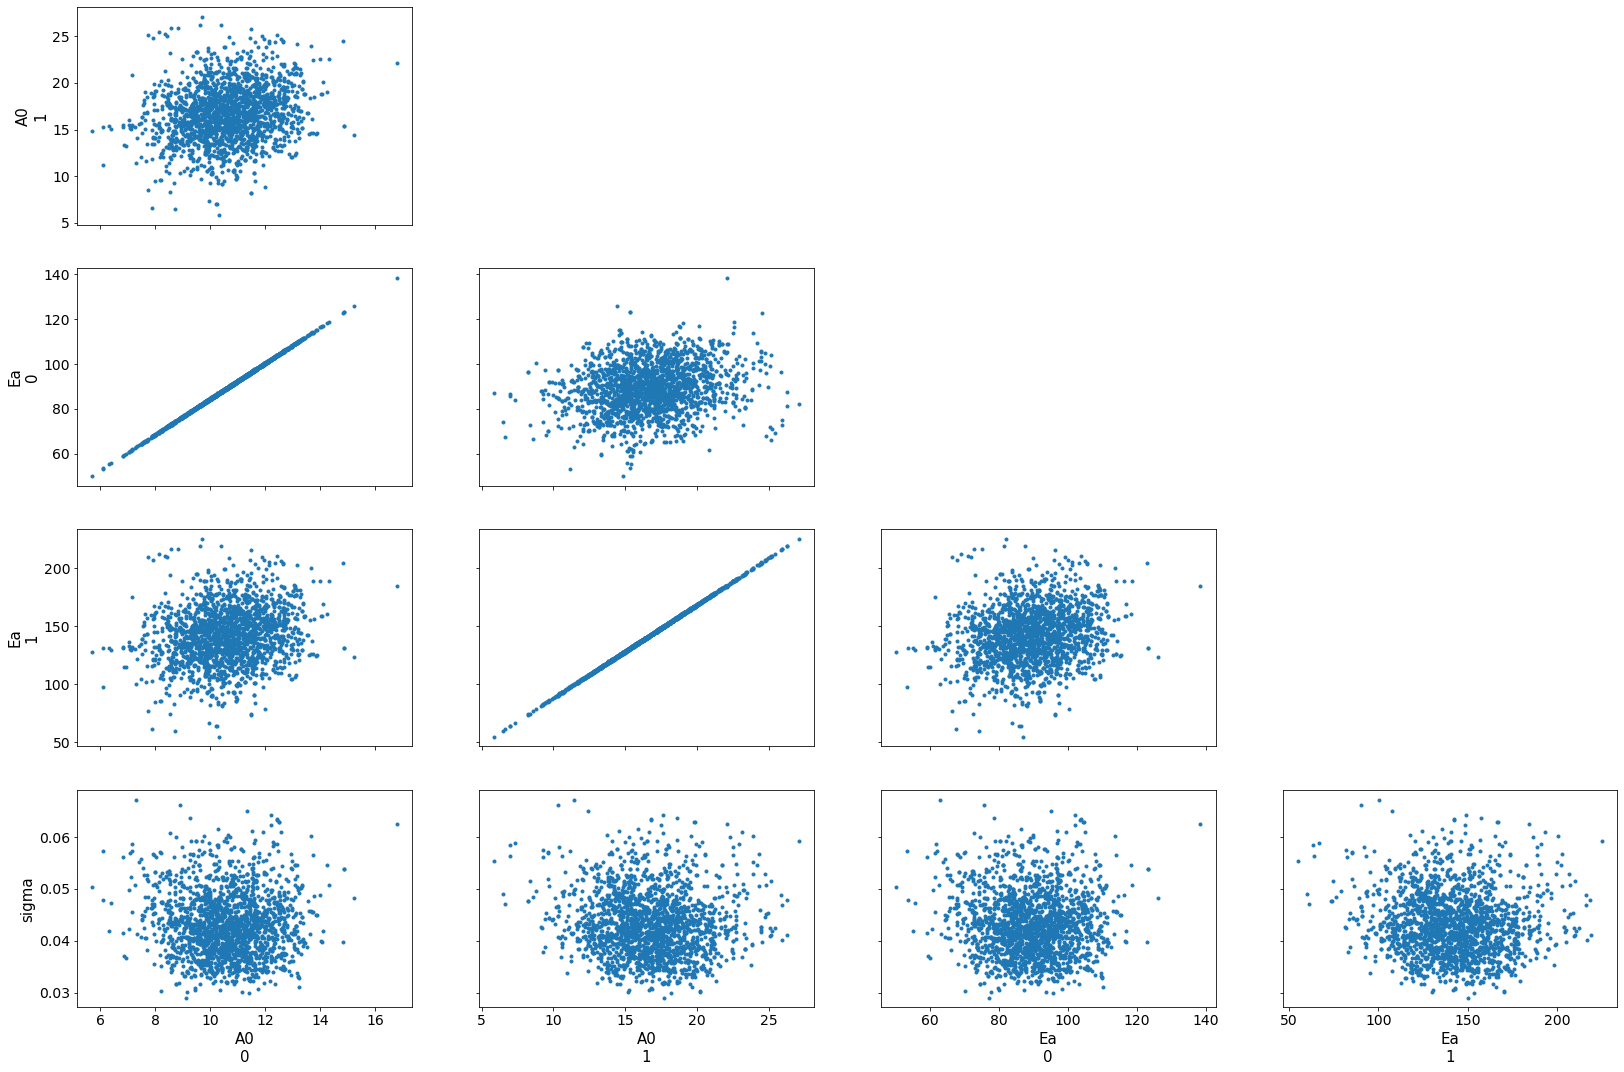

In [5]:
#Generate pairplot
arviz.plot_pair(m1)
plt.show()

Now, the VI estimation. This yields estimates of the posterior distributions of   
each parameter being estimated, but using the VI technique instead of the MCMC.     
VI is better than MCMC at generating a large number of samples, but is a less      
robust technique. It is still in its experimental implementation phase, and it       
does not iteract well with the PFR estimation module. We demonstrate this below.

In [6]:
#Run VI estimation with standard priors
v1, v2 = pfr.VI(filename=file, pH=True)

Using cached StanModel


RuntimeError: Exception: CVode failed with error flag -1  (in 'unknown file name' at line 65)


We can also specify prior distributions and run inference with them. The following   
example is for a prior distribution for the Ea term of rxn 1 that is normally distributed     
with a mean of 100 and standard deviation of 5 and a prior distribution for the A0 term   
of rxn 1 that is normally distributed with a mean of 10 and standard deviation of 5.   
All prior distribution specification must follow Stan's implementation forms:     
https://mc-stan.org/docs/2_23/functions-reference/unbounded-continuous-distributions.html

In [ ]:
#Run MCMC estimation with specified priors
p1, p2 = pfr.MCMC(filename=file, pH=True,
                            priors = ['A0[1] ~ normal(10,5)',
                                      'Ea[1] ~ normal(100,5)'])

Finally, we demonstrate how to construct visually appealing distribution plots.

In [ ]:
#Process datasets
data1 = m2['Ea'][:,0]
datalabel1 = 'MCMC Without Prior'
data1mean = np.mean(data1)
kdedata1 = gaussian_kde(data1)
data1x = np.linspace(min(data1), max(data1), 100)

data2 = p2['Ea'][:,0]
datalabel2 = 'MCMC With Prior'
data2mean = np.mean(data2)
kdedata2 = gaussian_kde(data2)
data2x = np.linspace(min(data2), max(data2), 100)

#Generate probability distribution graphs
sns.set(color_codes=True)
sns.set(style="white", font_scale=1.3)
f, ax = plt.subplots(1)
ax = sns.kdeplot(data1, gridsize=10000, shade=True, color='r')
ax = sns.kdeplot(data2, gridsize=10000, shade=True, color='b')
ax.axvline(data1mean, linestyle = "--", color = 'r')
ax.axvline(data2mean, linestyle = "--", color = 'b')
ax.set_title('Comparison of Inference Techniques')
ax.set_xlabel('$E_a [kJ/mol]$')
ax.set_ylabel('Probability Density')
ax.axes.get_yaxis().set_ticks([])
ax.axes.get_yaxis().set_ticklabels([])
ax.axes.set_xlim([50,125])
red_line = mpatches.Patch(color='red', label=datalabel1)
blue_line = mpatches.Patch(color='blue', label=datalabel2)
ax.legend(handles=[red_line, blue_line])
plt.show()